In [176]:
!pip install nltk

In [177]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [178]:
!python -m spacy download en_core_web_md

2024-02-02 00:01:10.934102: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 00:01:10.934165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 00:01:10.934962: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 00:01:11.829023: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 15.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [179]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string # special operations on strings
import spacy # language models

from matplotlib.pyplot import imread
from matplotlib import pyplot as plt
from wordcloud import WordCloud
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [180]:
tweets = pd.read_csv('Elon_musk.csv', encoding='Latin-1')
tweets.drop(['Unnamed: 0'],inplace=True,axis=1)
tweets

,Text
0,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...
...,...
1994,"@flcnhvy True, it sounds so surreal, but the n..."
1995,@PPathole Make sure to read ur terms &amp; con...
1996,@TeslaGong @PPathole Samwise Gamgee
1997,@PPathole Altho Dumb and Dumber is <U+0001F525...


# Data Exploration

#### Number of Words

In [181]:
tweets['word_count'] = tweets['Text'].apply(lambda x: len(str(x).split(" ")))
tweets[['Text','word_count']].head()

,Text,word_count
0,@kunalb11 Im an alien,4
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,13
2,@joerogan @Spotify Great interview!,4
3,@gtera27 Doge is underestimated,4
4,@teslacn Congratulations Tesla China for amazi...,17


#### Number of characters

In [182]:
tweets['character_count'] = tweets['Text'].str.len() ## this also includes spaces
tweets[['Text','character_count']].head()

,Text,character_count
0,@kunalb11 Im an alien,22
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,82
2,@joerogan @Spotify Great interview!,35
3,@gtera27 Doge is underestimated,31
4,@teslacn Congratulations Tesla China for amazi...,104


#### Average Word Length

In [183]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

tweets['avg_word'] = tweets['Text'].apply(lambda x: avg_word(x))
tweets[['Text','avg_word']].head()

,Text,avg_word
0,@kunalb11 Im an alien,4.750000
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,5.384615
2,@joerogan @Spotify Great interview!,8.000000
3,@gtera27 Doge is underestimated,7.000000
4,@teslacn Congratulations Tesla China for amazi...,5.176471


#### Number of special characters

In [184]:
tweets['hashtags'] = tweets['Text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
tweets[['Text','hashtags']].head()

,Text,hashtags
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,0
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


#### Number of numerics

In [185]:
tweets['numerics'] = tweets['Text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
tweets[['Text','numerics']].head()

,Text,numerics
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,0
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


#### Number of Uppercase words

In [186]:
tweets['upper_case'] = tweets['Text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
tweets[['Text','upper_case']].head()

,Text,upper_case
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,1
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


#### Number of Rare Words

In [187]:
freq = pd.Series(' '.join(tweets['Text']).split()).value_counts()[-10:]
freq

N3                         1
lab                        1
(N1                        1
detection                  1
Lab                        1
https://t.co/K77wXQ11yt    1
dicey                      1
accurate,                  1
thinks                     1
28                         1
dtype: int64

#### Percentage of Links attached in the tweets

In [188]:
tweets.Text.str.contains('https://').value_counts() / len(tweets)

False    0.678339
True     0.321661
Name: Text, dtype: float64

#### Percentage of User Tags in the tweets

In [189]:
tweets.Text.str.contains('@').value_counts() / len(tweets)

True     0.83942
False    0.16058
Name: Text, dtype: float64

#### Total number of Tweets in the available DataFrame

In [190]:
# Total tweets
print('Total tweets this period:', len(tweets.index), '\n')

Total tweets this period: 1999 



###  Spelling correction

In [191]:
from textblob import TextBlob
tweets['Text'][:5].apply(lambda x: str(TextBlob(x).correct()))

0                               @kunalb11 Im an alien
1    @ID_AA_Carmack May tracing on Cyberpunk with H...
2                   @joerogan @Notify Great interview!
3                       @gtera27 One is underestimated
4    @teslacn Congratulations Cela China for amazin...
Name: Text, dtype: object

In [192]:
TextBlob(tweets['Text'][3]).ngrams(1)

[WordList(['gtera27']),
 WordList(['Doge']),
 WordList(['is']),
 WordList(['underestimated'])]

In [193]:
TextBlob(tweets['Text'][2]).ngrams(2)

[WordList(['joerogan', 'Spotify']),
 WordList(['Spotify', 'Great']),
 WordList(['Great', 'interview'])]

In [194]:
TextBlob(tweets['Text'][4]).ngrams(3)

[WordList(['teslacn', 'Congratulations', 'Tesla']),
 WordList(['Congratulations', 'Tesla', 'China']),
 WordList(['Tesla', 'China', 'for']),
 WordList(['China', 'for', 'amazing']),
 WordList(['for', 'amazing', 'execution']),
 WordList(['amazing', 'execution', 'last']),
 WordList(['execution', 'last', 'year']),
 WordList(['last', 'year', 'Now']),
 WordList(['year', 'Now', 'on']),
 WordList(['Now', 'on', 'to']),
 WordList(['on', 'to', 'the']),
 WordList(['to', 'the', 'next']),
 WordList(['the', 'next', 'for']),
 WordList(['next', 'for', 'even']),
 WordList(['for', 'even', 'more'])]

# Data Visualization

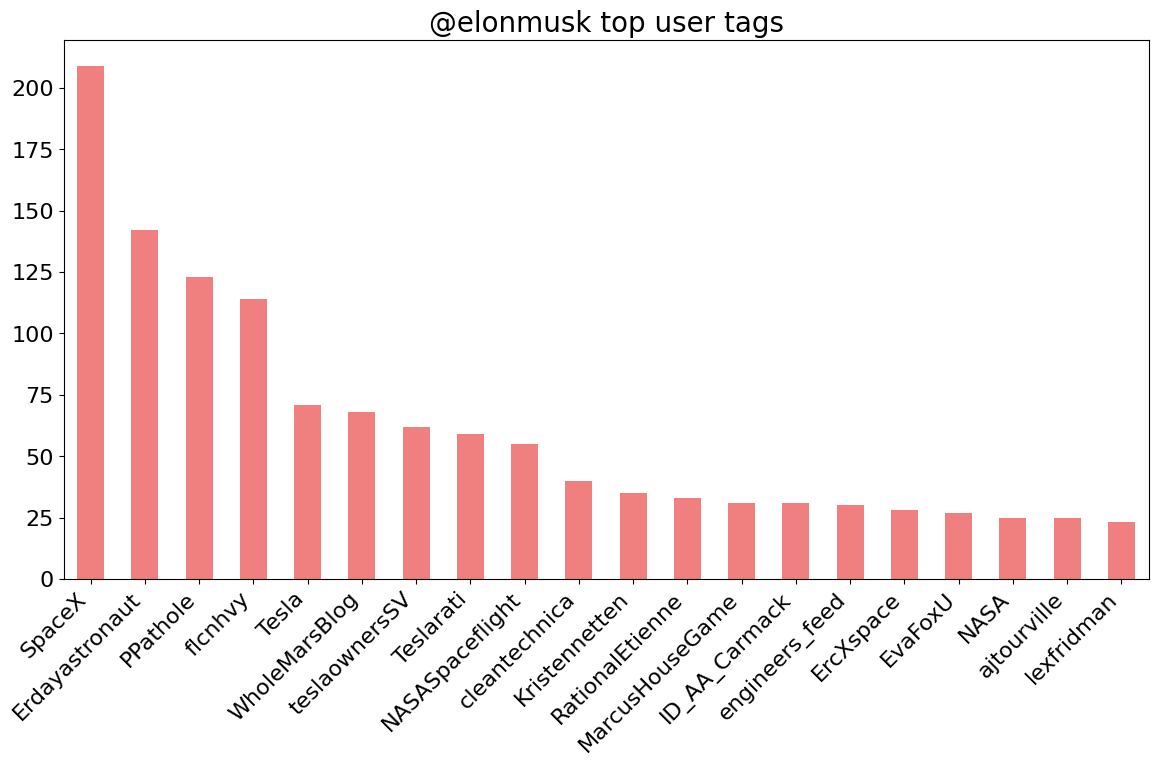

In [195]:
import itertools

c = list(
itertools.chain(
    *tweets.Text.map(lambda t: [handle.replace(":", "")[1:] for handle in t.split(" ")
                            if '@' in handle.replace(":", "")]).tolist())
)

pd.Series(c).value_counts().head(20).plot.bar(
    figsize=(14, 7), fontsize=16, color='lightcoral'
)
plt.gca().set_title('@elonmusk top user tags', fontsize=20)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, ha='right', fontsize=16)
pass

# Text PreProcessing

In [196]:
tweets=[Text.strip() for Text in tweets.Text] # remove both the leading and the trailing characters
tweets=[Text for Text in tweets if Text] # removes empty strings, because they are considered in Python as False
tweets[0:10]

['@kunalb11 I\x92m an alien',
 '@ID_AA_Carmack Ray tracing on Cyberpunk with HDR is next-level. Have you tried it?',
 '@joerogan @Spotify Great interview!',
 '@gtera27 Doge is underestimated',
 '@teslacn Congratulations Tesla China for amazing execution last year. Now on to the next for even more!!',
 'Happy New Year of the Ox! https://t.co/9WFKMYu2oj',
 'Frodo was the underdoge,\nAll thought he would fail,\nHimself most of all. https://t.co/zGxJFDzzrM',
 '@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :)',
 '@flcnhvy @anonyx10 Indeed! Tweets definitely do not represent real-world time allocation.',
 'The most entertaining outcome is the most likely']

In [197]:
# Joining the list into one string/text
tweets_text=' '.join(tweets)
tweets_text

'@kunalb11 I\x92m an alien @ID_AA_Carmack Ray tracing on Cyberpunk with HDR is next-level. Have you tried it? @joerogan @Spotify Great interview! @gtera27 Doge is underestimated @teslacn Congratulations Tesla China for amazing execution last year. Now on to the next for even more!! Happy New Year of the Ox! https://t.co/9WFKMYu2oj Frodo was the underdoge,\nAll thought he would fail,\nHimself most of all. https://t.co/zGxJFDzzrM @OwenSparks_ @flcnhvy @anonyx10 Haha thanks :) @flcnhvy @anonyx10 Indeed! Tweets definitely do not represent real-world time allocation. The most entertaining outcome is the most likely @GiveDirectly Just sent some Just agree to do Clubhouse with @kanyewest https://t.co/3rWE9uHSTS @geoffkeighley @UnrealEngine It\x92s getting real Bought some Dogecoin for lil X, so he can be a toddler hodler @JoshManMode He definitely has issues, but the sentencing seems a bit high @freewalletorg Thanks for fixing @freewalletorg Please unlock my account @AstroJordy <U+0001F923><U

In [198]:
# remove Twitter username handles from a given twitter text. (Removes @usernames)
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer(strip_handles=True)
tweets_tokens=tokenizer.tokenize(tweets_text)
print(tweets_tokens)

['I', '\x92', 'm', 'an', 'alien', 'Ray', 'tracing', 'on', 'Cyberpunk', 'with', 'HDR', 'is', 'next-level', '.', 'Have', 'you', 'tried', 'it', '?', 'Great', 'interview', '!', 'Doge', 'is', 'underestimated', 'Congratulations', 'Tesla', 'China', 'for', 'amazing', 'execution', 'last', 'year', '.', 'Now', 'on', 'to', 'the', 'next', 'for', 'even', 'more', '!', '!', 'Happy', 'New', 'Year', 'of', 'the', 'Ox', '!', 'https://t.co/9WFKMYu2oj', 'Frodo', 'was', 'the', 'underdoge', ',', 'All', 'thought', 'he', 'would', 'fail', ',', 'Himself', 'most', 'of', 'all', '.', 'https://t.co/zGxJFDzzrM', 'Haha', 'thanks', ':)', 'Indeed', '!', 'Tweets', 'definitely', 'do', 'not', 'represent', 'real-world', 'time', 'allocation', '.', 'The', 'most', 'entertaining', 'outcome', 'is', 'the', 'most', 'likely', 'Just', 'sent', 'some', 'Just', 'agree', 'to', 'do', 'Clubhouse', 'with', 'https://t.co/3rWE9uHSTS', 'It', '\x92', 's', 'getting', 'real', 'Bought', 'some', 'Dogecoin', 'for', 'lil', 'X', ',', 'so', 'he', 'can'

In [199]:
# Again Joining the list into one string/text
tweets_tokens_text=' '.join(tweets_tokens)
tweets_tokens_text

'I \x92 m an alien Ray tracing on Cyberpunk with HDR is next-level . Have you tried it ? Great interview ! Doge is underestimated Congratulations Tesla China for amazing execution last year . Now on to the next for even more ! ! Happy New Year of the Ox ! https://t.co/9WFKMYu2oj Frodo was the underdoge , All thought he would fail , Himself most of all . https://t.co/zGxJFDzzrM Haha thanks :) Indeed ! Tweets definitely do not represent real-world time allocation . The most entertaining outcome is the most likely Just sent some Just agree to do Clubhouse with https://t.co/3rWE9uHSTS It \x92 s getting real Bought some Dogecoin for lil X , so he can be a toddler hodler He definitely has issues , but the sentencing seems a bit high Thanks for fixing Please unlock my account <U+0001F923> <U+0001F923> This is true power haha https://t.co/Fc9uhQSd7O Any crypto wallet that won \x92 t give you your private keys should be avoided at all costs Your app sucks RT : NASA has selected Falcon Heavy to 

In [200]:
# Remove Punctuations
no_punc_text=tweets_tokens_text.translate(str.maketrans('','',string.punctuation))
no_punc_text

'I \x92 m an alien Ray tracing on Cyberpunk with HDR is nextlevel  Have you tried it  Great interview  Doge is underestimated Congratulations Tesla China for amazing execution last year  Now on to the next for even more   Happy New Year of the Ox  httpstco9WFKMYu2oj Frodo was the underdoge  All thought he would fail  Himself most of all  httpstcozGxJFDzzrM Haha thanks  Indeed  Tweets definitely do not represent realworld time allocation  The most entertaining outcome is the most likely Just sent some Just agree to do Clubhouse with httpstco3rWE9uHSTS It \x92 s getting real Bought some Dogecoin for lil X  so he can be a toddler hodler He definitely has issues  but the sentencing seems a bit high Thanks for fixing Please unlock my account U0001F923 U0001F923 This is true power haha httpstcoFc9uhQSd7O Any crypto wallet that won \x92 t give you your private keys should be avoided at all costs Your app sucks RT  NASA has selected Falcon Heavy to launch the first two elements of the lunar Ga

In [201]:
# remove https or url within text
import re
no_url_text=re.sub(r'http\S+', '', no_punc_text)
no_url_text

'I \x92 m an alien Ray tracing on Cyberpunk with HDR is nextlevel  Have you tried it  Great interview  Doge is underestimated Congratulations Tesla China for amazing execution last year  Now on to the next for even more   Happy New Year of the Ox   Frodo was the underdoge  All thought he would fail  Himself most of all   Haha thanks  Indeed  Tweets definitely do not represent realworld time allocation  The most entertaining outcome is the most likely Just sent some Just agree to do Clubhouse with  It \x92 s getting real Bought some Dogecoin for lil X  so he can be a toddler hodler He definitely has issues  but the sentencing seems a bit high Thanks for fixing Please unlock my account U0001F923 U0001F923 This is true power haha  Any crypto wallet that won \x92 t give you your private keys should be avoided at all costs Your app sucks RT  NASA has selected Falcon Heavy to launch the first two elements of the lunar Gateway together on one mission   Yes Once we can predict cash flow reason

In [202]:
from nltk.tokenize import word_tokenize
text_tokens=word_tokenize(no_url_text)
print(text_tokens)

['I', '\x92', 'm', 'an', 'alien', 'Ray', 'tracing', 'on', 'Cyberpunk', 'with', 'HDR', 'is', 'nextlevel', 'Have', 'you', 'tried', 'it', 'Great', 'interview', 'Doge', 'is', 'underestimated', 'Congratulations', 'Tesla', 'China', 'for', 'amazing', 'execution', 'last', 'year', 'Now', 'on', 'to', 'the', 'next', 'for', 'even', 'more', 'Happy', 'New', 'Year', 'of', 'the', 'Ox', 'Frodo', 'was', 'the', 'underdoge', 'All', 'thought', 'he', 'would', 'fail', 'Himself', 'most', 'of', 'all', 'Haha', 'thanks', 'Indeed', 'Tweets', 'definitely', 'do', 'not', 'represent', 'realworld', 'time', 'allocation', 'The', 'most', 'entertaining', 'outcome', 'is', 'the', 'most', 'likely', 'Just', 'sent', 'some', 'Just', 'agree', 'to', 'do', 'Clubhouse', 'with', 'It', '\x92', 's', 'getting', 'real', 'Bought', 'some', 'Dogecoin', 'for', 'lil', 'X', 'so', 'he', 'can', 'be', 'a', 'toddler', 'hodler', 'He', 'definitely', 'has', 'issues', 'but', 'the', 'sentencing', 'seems', 'a', 'bit', 'high', 'Thanks', 'for', 'fixing',

In [203]:
# Tokenization
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [204]:
# Tokens count
len(text_tokens)

17847

In [205]:
# Remove Stopwords
from nltk.corpus import stopwords
my_stop_words=stopwords.words('english')

sw_list = ['\x92','rt','ye','yeah','haha','Yes','U0001F923','I']
my_stop_words.extend(sw_list)

no_stop_tokens=[word for word in text_tokens if not word in my_stop_words]
print(no_stop_tokens)

['alien', 'Ray', 'tracing', 'Cyberpunk', 'HDR', 'nextlevel', 'Have', 'tried', 'Great', 'interview', 'Doge', 'underestimated', 'Congratulations', 'Tesla', 'China', 'amazing', 'execution', 'last', 'year', 'Now', 'next', 'even', 'Happy', 'New', 'Year', 'Ox', 'Frodo', 'underdoge', 'All', 'thought', 'would', 'fail', 'Himself', 'Haha', 'thanks', 'Indeed', 'Tweets', 'definitely', 'represent', 'realworld', 'time', 'allocation', 'The', 'entertaining', 'outcome', 'likely', 'Just', 'sent', 'Just', 'agree', 'Clubhouse', 'It', 'getting', 'real', 'Bought', 'Dogecoin', 'lil', 'X', 'toddler', 'hodler', 'He', 'definitely', 'issues', 'sentencing', 'seems', 'bit', 'high', 'Thanks', 'fixing', 'Please', 'unlock', 'account', 'This', 'true', 'power', 'Any', 'crypto', 'wallet', 'give', 'private', 'keys', 'avoided', 'costs', 'Your', 'app', 'sucks', 'RT', 'NASA', 'selected', 'Falcon', 'Heavy', 'launch', 'first', 'two', 'elements', 'lunar', 'Gateway', 'together', 'one', 'mission', 'Once', 'predict', 'cash', 'flo

In [206]:
# Normalizing the data
lower_words=[Text.lower() for Text in no_stop_tokens]
print(lower_words[100:200])

['once', 'predict', 'cash', 'flow', 'reasonably', 'well', 'starlink', 'ipo', 'starlink', 'staggeringly', 'difficult', 'technical', 'economic', 'endeavor', 'however', 'spacex', 'needs', 'pass', 'deep', 'chasm', 'negative', 'cash', 'flow', 'next', 'year', 'lowest', 'cost', 'per', 'ton', 'carbon', 'sequestered', 'net', 'value', 'product', 'made', 'must', 'scalable', 'g', 'it', 'meant', 'price', 'countries', 'only', 'difference', 'taxes', 'shipping', 'this', 'intended', 'earth', 'may', 'ideas', 'apply', 'mars', 'xprize', 'team', 'manage', '100m', 'carbon', 'capture', 'prize', 'everyone', 'tesla', 'receives', 'stock', 'my', 'comp', 'stock', 'options', 'take', 'table', 'that', 'missing', 'back', 'work', 'go', 'does', 'seem', 'bit', 'high', 'doge', 'appears', 'inflationary', 'meaningfully', 'fixed', 'coins', 'per', 'unit', 'time', 'whereas', 'wow', '1', 'orbital', 'launch', 'tower', 'stack', '2', 'enough', 'raptors', 'orbit', 'booster']


In [207]:
# Stemming (Optional)
from nltk.stem import PorterStemmer
ps=PorterStemmer()
stemmed_tokens=[ps.stem(word) for word in lower_words]
print(stemmed_tokens[100:200])

['onc', 'predict', 'cash', 'flow', 'reason', 'well', 'starlink', 'ipo', 'starlink', 'staggeringli', 'difficult', 'technic', 'econom', 'endeavor', 'howev', 'spacex', 'need', 'pass', 'deep', 'chasm', 'neg', 'cash', 'flow', 'next', 'year', 'lowest', 'cost', 'per', 'ton', 'carbon', 'sequest', 'net', 'valu', 'product', 'made', 'must', 'scalabl', 'g', 'it', 'meant', 'price', 'countri', 'onli', 'differ', 'tax', 'ship', 'thi', 'intend', 'earth', 'may', 'idea', 'appli', 'mar', 'xprize', 'team', 'manag', '100m', 'carbon', 'captur', 'prize', 'everyon', 'tesla', 'receiv', 'stock', 'my', 'comp', 'stock', 'option', 'take', 'tabl', 'that', 'miss', 'back', 'work', 'go', 'doe', 'seem', 'bit', 'high', 'doge', 'appear', 'inflationari', 'meaning', 'fix', 'coin', 'per', 'unit', 'time', 'wherea', 'wow', '1', 'orbit', 'launch', 'tower', 'stack', '2', 'enough', 'raptor', 'orbit', 'booster']


In [208]:
# Lemmatization
nlp = spacy.load('en_core_web_sm')
doc = nlp(' '.join(lower_words))
print(doc)

alien ray tracing cyberpunk hdr nextlevel have tried great interview doge underestimated congratulations tesla china amazing execution last year now next even happy new year ox frodo underdoge all thought would fail himself haha thanks indeed tweets definitely represent realworld time allocation the entertaining outcome likely just sent just agree clubhouse it getting real bought dogecoin lil x toddler hodler he definitely issues sentencing seems bit high thanks fixing please unlock account this true power any crypto wallet give private keys avoided costs your app sucks rt nasa selected falcon heavy launch first two elements lunar gateway together one mission once predict cash flow reasonably well starlink ipo starlink staggeringly difficult technical economic endeavor however spacex needs pass deep chasm negative cash flow next year lowest cost per ton carbon sequestered net value product made must scalable g it meant price countries only difference taxes shipping this intended earth 

In [209]:
lemmas=[token.lemma_ for token in doc]
print(lemmas)

['alien', 'ray', 'trace', 'cyberpunk', 'hdr', 'nextlevel', 'have', 'try', 'great', 'interview', 'doge', 'underestimate', 'congratulation', 'tesla', 'china', 'amazing', 'execution', 'last', 'year', 'now', 'next', 'even', 'happy', 'new', 'year', 'ox', 'frodo', 'underdoge', 'all', 'thought', 'would', 'fail', 'himself', 'haha', 'thank', 'indeed', 'tweet', 'definitely', 'represent', 'realworld', 'time', 'allocation', 'the', 'entertaining', 'outcome', 'likely', 'just', 'send', 'just', 'agree', 'clubhouse', 'it', 'get', 'real', 'buy', 'dogecoin', 'lil', 'x', 'toddler', 'hodler', 'he', 'definitely', 'issue', 'sentencing', 'seem', 'bit', 'high', 'thank', 'fix', 'please', 'unlock', 'account', 'this', 'true', 'power', 'any', 'crypto', 'wallet', 'give', 'private', 'key', 'avoid', 'cost', 'your', 'app', 'suck', 'rt', 'nasa', 'select', 'falcon', 'heavy', 'launch', 'first', 'two', 'element', 'lunar', 'gateway', 'together', 'one', 'mission', 'once', 'predict', 'cash', 'flow', 'reasonably', 'well', 'st

In [210]:
cleaned_tweets=' '.join(lemmas)
cleaned_tweets

'alien ray trace cyberpunk hdr nextlevel have try great interview doge underestimate congratulation tesla china amazing execution last year now next even happy new year ox frodo underdoge all thought would fail himself haha thank indeed tweet definitely represent realworld time allocation the entertaining outcome likely just send just agree clubhouse it get real buy dogecoin lil x toddler hodler he definitely issue sentencing seem bit high thank fix please unlock account this true power any crypto wallet give private key avoid cost your app suck rt nasa select falcon heavy launch first two element lunar gateway together one mission once predict cash flow reasonably well starlink ipo starlink staggeringly difficult technical economic endeavor however spacex need pass deep chasm negative cash flow next year low cost per ton carbon sequester net value product make must scalable g it mean price country only difference taxis ship this intend earth may idea apply mar xprize team manage 100 m

# Feature Extaction

## 1) using Countvectorizer

In [211]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()
tweetscv=cv.fit_transform(lemmas)

In [212]:
print(cv.vocabulary_)

{'alien': 194, 'ray': 2347, 'trace': 3012, 'cyberpunk': 767, 'hdr': 1358, 'nextlevel': 1960, 'have': 1353, 'try': 3043, 'great': 1305, 'interview': 1556, 'doge': 890, 'underestimate': 3176, 'congratulation': 675, 'tesla': 2917, 'china': 584, 'amazing': 217, 'execution': 1057, 'last': 1640, 'year': 3392, 'now': 1988, 'next': 1959, 'even': 1031, 'happy': 1340, 'new': 1957, 'ox': 2089, 'frodo': 1207, 'underdoge': 3175, 'all': 197, 'thought': 2954, 'would': 3378, 'fail': 1091, 'himself': 1402, 'haha': 1328, 'thank': 2928, 'indeed': 1497, 'tweet': 3058, 'definitely': 804, 'represent': 2414, 'realworld': 2362, 'time': 2970, 'allocation': 199, 'the': 2933, 'entertaining': 1001, 'outcome': 2068, 'likely': 1695, 'just': 1598, 'send': 2557, 'agree': 179, 'clubhouse': 613, 'it': 1575, 'get': 1266, 'real': 2357, 'buy': 502, 'dogecoin': 892, 'lil': 1696, 'toddler': 2982, 'hodler': 1408, 'he': 1359, 'issue': 1574, 'sentencing': 2562, 'seem': 2549, 'bit': 418, 'high': 1393, 'fix': 1152, 'please': 218

In [213]:
print(cv.get_feature_names_out()[100:200])

['74' '78' '7th' '90' '9007' '922' '948' '95' '99' 'aber' 'able' 'abo'
 'aboard' 'abort' 'about' 'above' 'absence' 'absolute' 'absolutely'
 'absorb' 'absorption' 'absurd' 'absurdly' 'ac' 'academia' 'accel'
 'accelera' 'accelerate' 'acceleration' 'accelerator' 'accept'
 'acceptable' 'access' 'accessible' 'accident' 'accidental' 'accommodate'
 'account' 'accura' 'accuracy' 'accurate' 'ace' 'achieve' 'achievement'
 'achy' 'acquisition' 'across' 'action' 'active' 'activity' 'actual'
 'actuall' 'actually' 'actuary' 'adagio' 'add' 'additive' 'address'
 'administer' 'adult' 'advanc' 'advance' 'advanced' 'advantage'
 'adventure' 'advertise' 'advice' 'advise' 'aero' 'afb' 'affair' 'affect'
 'affordable' 'africa' 'after' 'afternoon' 'age' 'ago' 'agony' 'agree'
 'ah' 'ahead' 'ahem' 'ai' 'aim' 'air' 'aircraft' 'airplane' 'ak' 'aka'
 'alert' 'alexander' 'algo' 'algorithm' 'alien' 'aliens' 'align' 'all'
 'allocati' 'allocation']


In [214]:
print(tweetscv.toarray()[100:200])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [215]:
print(tweetscv.toarray().shape)

(11486, 3412)


## 2) CountVectorizer with N-grams (Bigrams & Trigrams)

In [216]:
cv_ngram_range=CountVectorizer(analyzer='word',ngram_range=(1,3),max_features=100)
bow_matrix_ngram=cv_ngram_range.fit_transform(lemmas)

In [217]:
print(cv_ngram_range.get_feature_names_out())
print(bow_matrix_ngram.toarray())

['actually' 'ai' 'also' 'back' 'big' 'booster' 'car' 'come' 'cool' 'could'
 'crew' 'day' 'design' 'do' 'dragon' 'earth' 'engine' 'even' 'ever'
 'exactly' 'falcon' 'first' 'flight' 'fsd' 'future' 'get' 'go' 'good'
 'great' 'haha' 'hard' 'high' 'if' 'it' 'just' 'land' 'launch' 'like'
 'look' 'lot' 'make' 'many' 'mar' 'maybe' 'mission' 'model' 'month' 'much'
 'need' 'new' 'next' 'no' 'not' 'ok' 'one' 'part' 'people' 'point'
 'pretty' 'probably' 'production' 'right' 'rocket' 'rt' 'say' 'seem'
 'soon' 'space' 'spacex' 'starlink' 'starship' 'start' 'still' 'super'
 'sure' 'take' 'tesla' 'test' 'thank' 'that' 'the' 'there' 'they' 'think'
 'this' 'time' 'true' 'try' 'ufe0f' 'use' 'way' 'we' 'week' 'well' 'will'
 'work' 'would' 'yeah' 'year' 'you']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## 3)TF-IDF Vectorizer

In [218]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfv_ngram_max_features=TfidfVectorizer(norm='l2',analyzer='word',ngram_range=(1,3),max_features=500)
tfidf_matix_ngram=tfidfv_ngram_max_features.fit_transform(lemmas)

In [219]:
print(tfidfv_ngram_max_features.get_feature_names_out())
print(tfidf_matix_ngram.toarray())

['10' '100' '13' '20' '2020' '30' '40' '4d' '60' 'able' 'absolutely'
 'access' 'accurate' 'actually' 'add' 'after' 'ago' 'agree' 'ai' 'aim'
 'air' 'all' 'almost' 'already' 'also' 'although' 'always' 'amazing' 'and'
 'another' 'appear' 'apply' 'appreciate' 'approval' 'arm' 'around'
 'article' 'as' 'astronaut' 'at' 'autopilot' 'awesome' 'back' 'bad' 'bar'
 'base' 'battery' 'be' 'become' 'berlin' 'beta' 'big' 'bit' 'boca' 'body'
 'booster' 'brain' 'bring' 'bs' 'build' 'burn' 'but' 'buy' 'cake' 'call'
 'camera' 'can' 'car' 'cargo' 'catch' 'cell' 'ch4' 'chance' 'change'
 'china' 'civilization' 'close' 'cold' 'color' 'come' 'company' 'complete'
 'computer' 'confirm' 'congratulation' 'control' 'cool' 'cost' 'could'
 'course' 'cov' 'crazy' 'create' 'crew' 'critical' 'curevac' 'cyberpunk'
 'cybertruck' 'datum' 'day' 'deep' 'definitely' 'delivery' 'design'
 'detail' 'difference' 'different' 'do' 'dock' 'doge' 'dojo' 'dragon'
 'drive' 'droneship' 'due' 'dumb' 'early' 'earth' 'easy' 'electric'
 'e

# Generating Wordcloud

In [220]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud)
    # No axis details
    plt.axis("off");

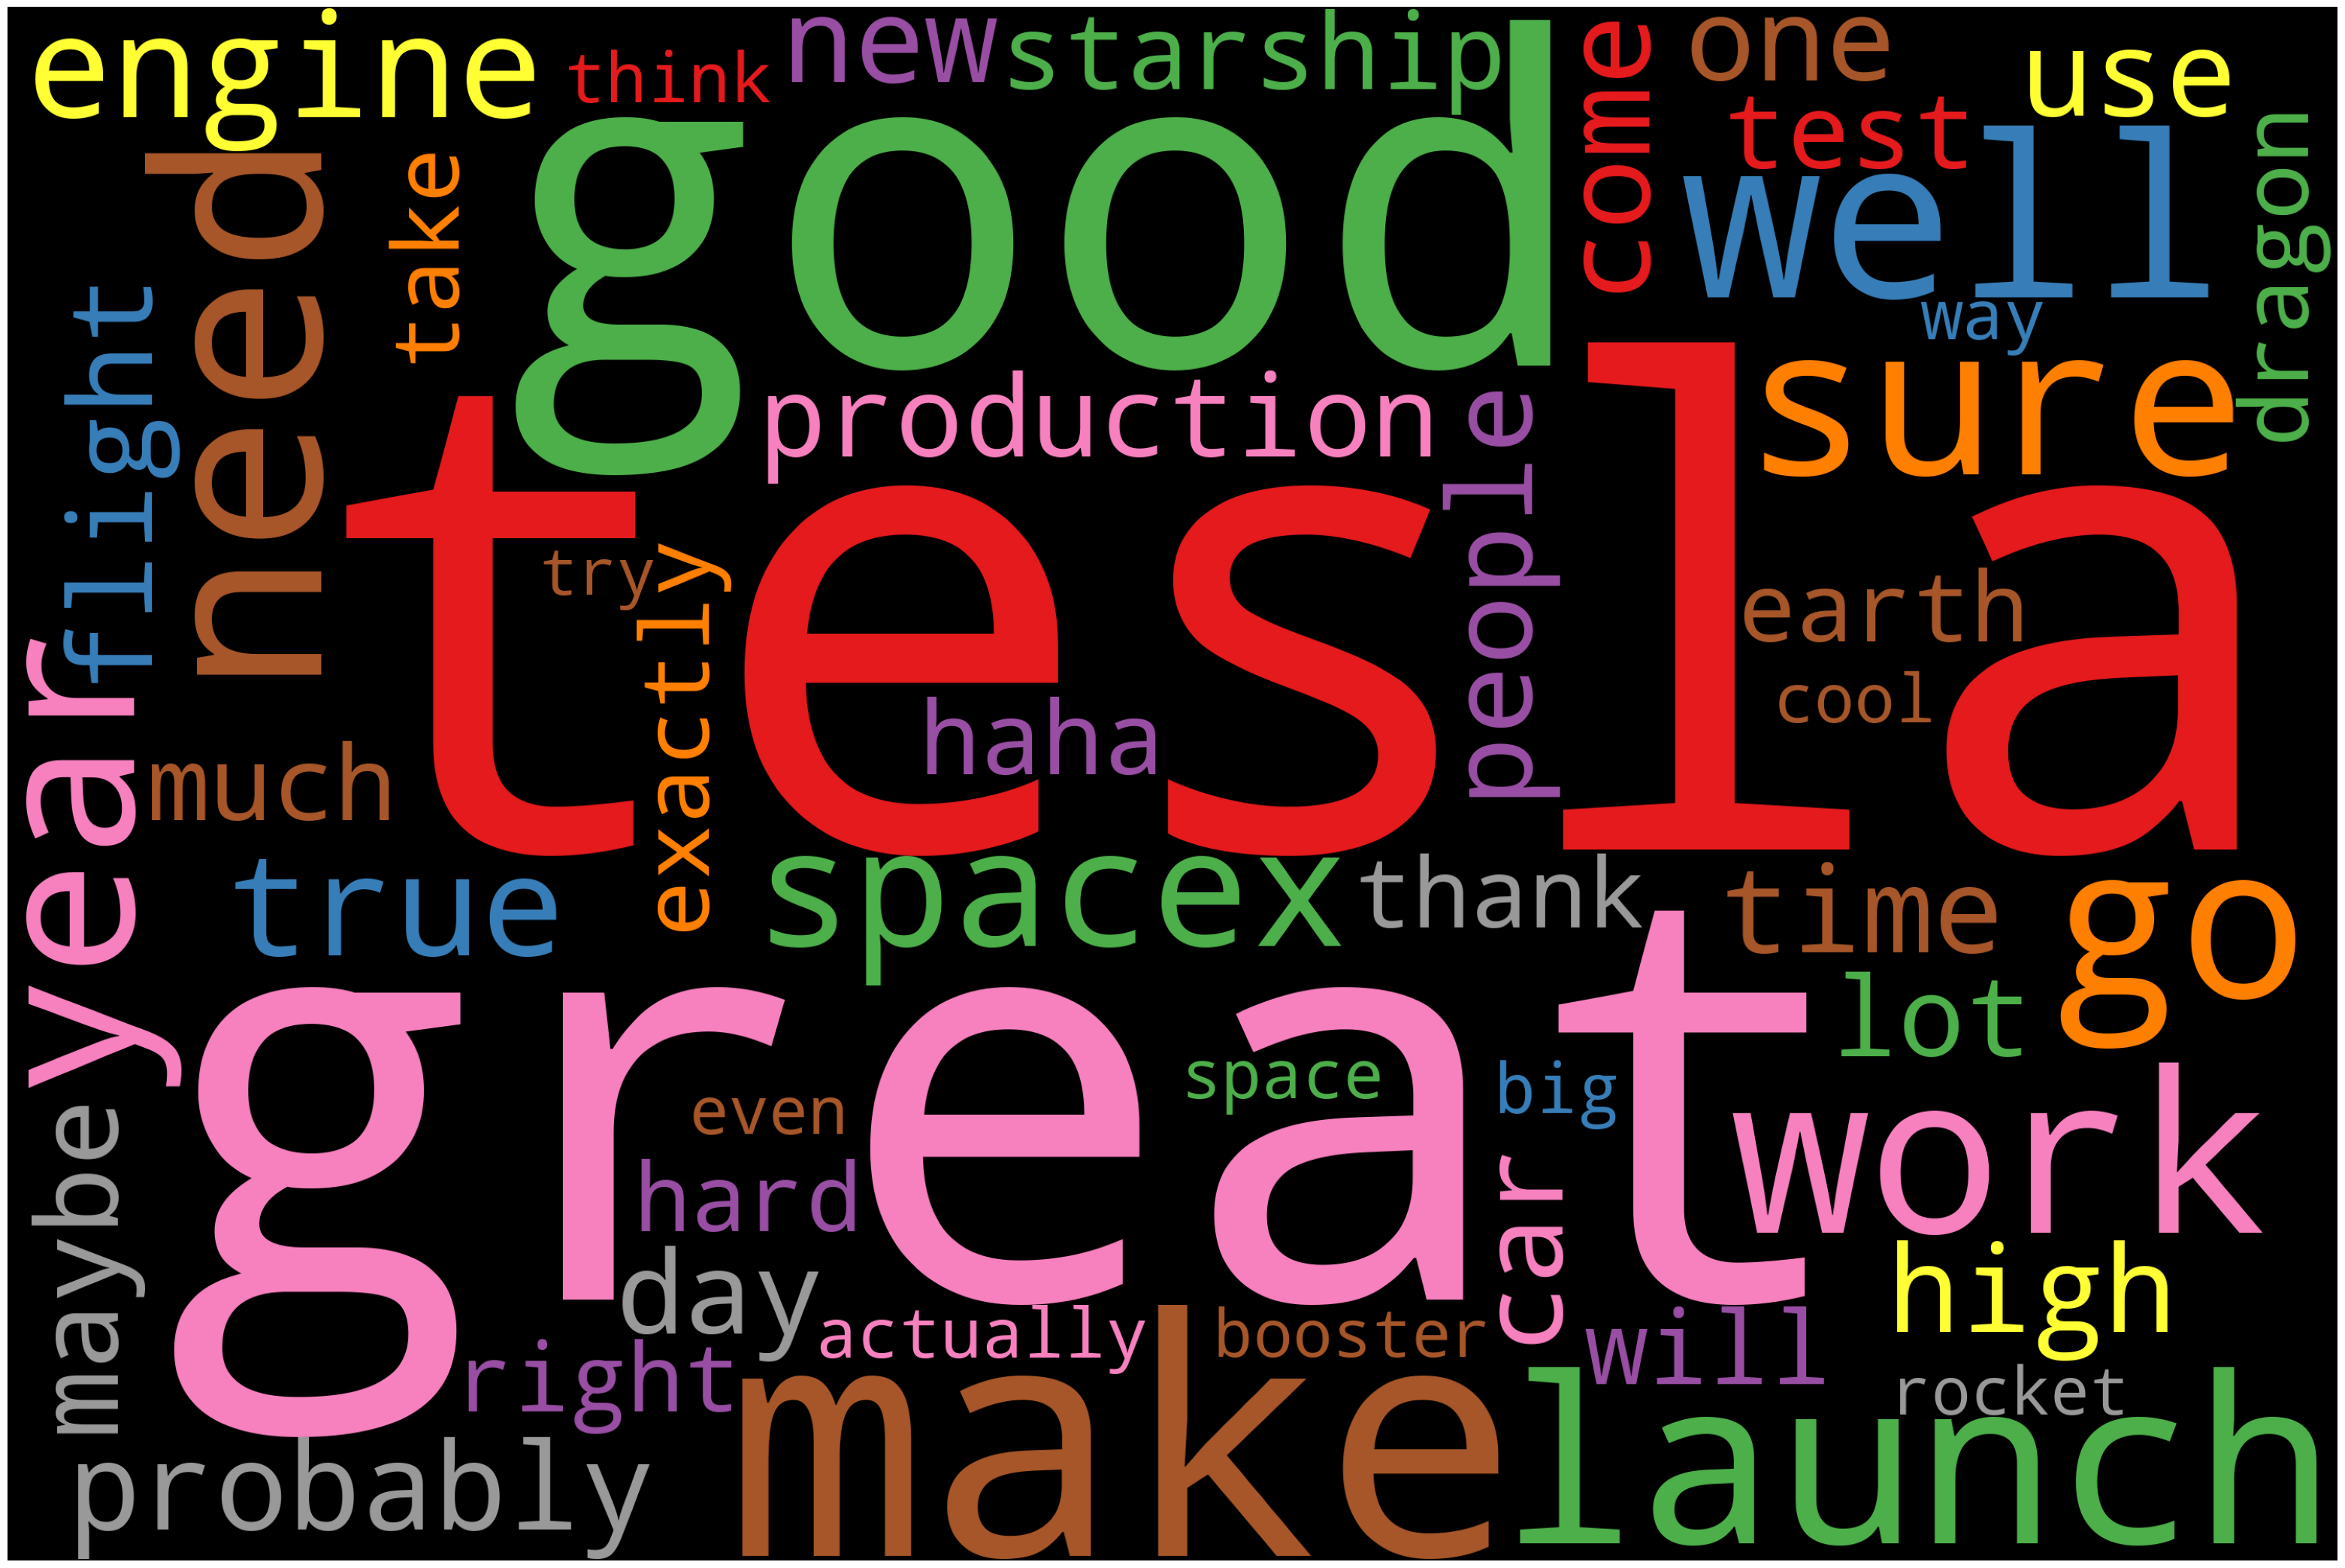

In [221]:
# Generate Word Cloud

STOPWORDS.add('pron')
STOPWORDS.add('rt')
STOPWORDS.add('yeah')
wordcloud = WordCloud(width=3000,height=2000,background_color='black',max_words=50,
                   colormap='Set1',stopwords=STOPWORDS).generate(cleaned_tweets)
plot_cloud(wordcloud)

#     

# Named Entity Recognition (NER)

In [222]:
# Parts Of Speech (POS) Tagging
nlp=spacy.load('en_core_web_sm')

one_block=cleaned_tweets
doc_block=nlp(one_block)
spacy.displacy.render(doc_block,style='ent',jupyter=True)

In [223]:
for token in doc_block[100:200]:
    print(token,token.pos_)

once ADV
predict VERB
cash NOUN
flow NOUN
reasonably ADV
well ADV
starlink NOUN
ipo PROPN
starlink NOUN
staggeringly ADV
difficult ADJ
technical ADJ
economic ADJ
endeavor NOUN
however ADV
spacex VERB
need AUX
pass VERB
deep ADJ
chasm ADJ
negative ADJ
cash NOUN
flow NOUN
next ADJ
year NOUN
low ADJ
cost NOUN
per ADP
ton NOUN
carbon NOUN
sequester NOUN
net ADJ
value NOUN
product NOUN
make VERB
must AUX
scalable VERB
g ADP
it PRON
mean VERB
price NOUN
country NOUN
only ADV
difference NOUN
taxis NOUN
ship NOUN
this PRON
intend VERB
earth NOUN
may AUX
idea NOUN
apply VERB
mar PROPN
xprize PROPN
team NOUN
manage VERB
100 NUM
m PROPN
carbon NOUN
capture NOUN
prize NOUN
everyone PRON
tesla NOUN
receive VERB
stock NOUN
my PRON
comp NOUN
stock NOUN
option NOUN
take VERB
table NOUN
that PRON
miss VERB
back ADP
work NOUN
go VERB
do AUX
seem VERB
bit NOUN
high ADJ
doge PROPN
appear VERB
inflationary ADJ
meaningfully ADV
fix VERB
coin PROPN
per ADP
unit NOUN
time NOUN
whereas SCONJ
wow INTJ
1 NUM
orb

In [224]:
# Filtering the nouns and verbs only
nouns_verbs=[token.text for token in doc_block if token.pos_ in ('NOUN','VERB')]
print(nouns_verbs[100:200])

['time', 'launch', 'tower', 'stack', 'raptor', 'orbit', 'booster', 'improve', 'ship', 'booster', 'mass', 'back', 'work', 'tonight', 'video', 'people', 'speak', 'cute', 'image', 'reflect', 'time', 'cost', 'people', 'rain', 'pain', 'u0001f3b6', 'let', 'doge', 'rainforest', 'come', 'crypto', 'simplicity', 'genius', 'decade', 'work', 'look', 'note', 'email', 'text', 'lesson', 'learn', 'earth', 'time', 'tell', 'story', 'tesla', 'read', 'kingdom', 'hear', 'name', 'year', 'dogecake', 'thing', 'restaurant', 'hang', 'currency', 'earth', 'scratch', 'destiny', 'franz', 'say', 'ship', 'landing', 'burn', 'solution', 'greate', 'use', 'gas', 'maneuvering', 'rcs', 'thruster', 'seem', 'raptor', 'launch', 'mission', 'collect', 'datum', 'galaxy', 'explore', 'launch', 'starlink', 'satellite', 'orbit', 'mission', 'pad', '39a', 'deck', 'default', 'engine', 'lever', 'arm', 'shut', 'engine', 'min', 'throttle', 'point', 'flameout', 'risk', 'start', 'engine']


In [225]:
# Counting the noun & verb tokens
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()

X=cv.fit_transform(nouns_verbs)
sum_words=X.sum(axis=0)

words_freq=[(word,sum_words[0,idx]) for word,idx in cv.vocabulary_.items()]
words_freq=sorted(words_freq, key=lambda x: x[1], reverse=True)

wd_df=pd.DataFrame(words_freq)
wd_df.columns=['word','count']
wd_df[0:10] # viewing top ten results

,word,count
0,tesla,76
1,make,64
2,launch,62
3,year,49
4,work,49
5,need,48
6,go,43
7,come,42
8,day,38
9,get,37


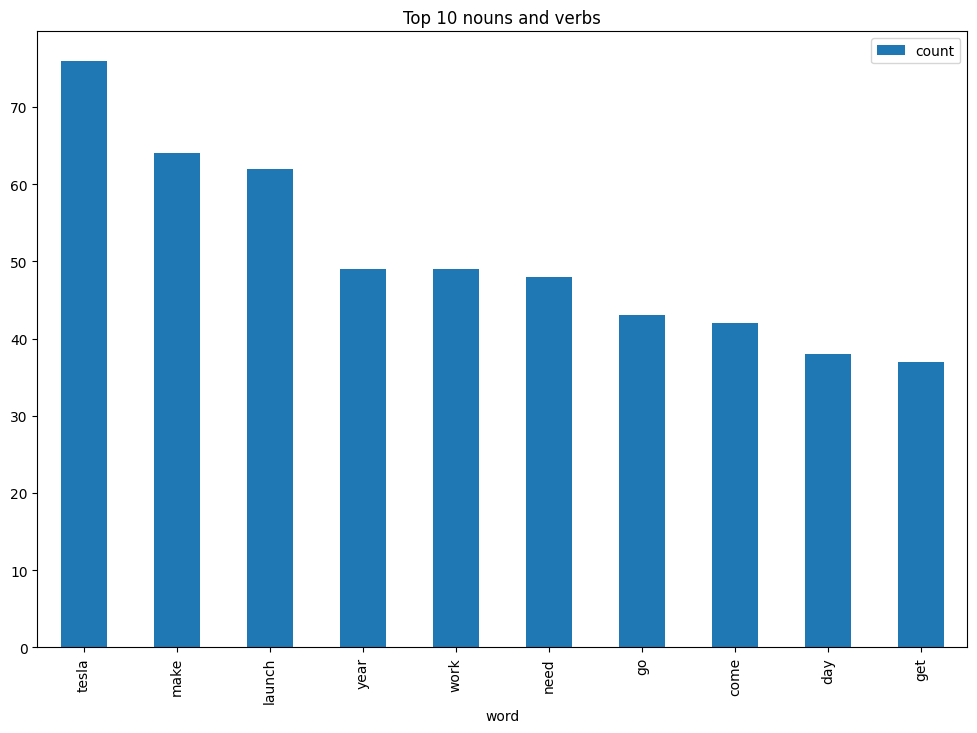

In [226]:
# Visualizing results (Barchart for top 10 nouns + verbs)
wd_df[0:10].plot.bar(x='word',figsize=(12,8),title='Top 10 nouns and verbs');

# Emotion Mining - Sentiment Analysis

In [227]:
from nltk import tokenize
sentences=tokenize.sent_tokenize(' '.join(tweets))
sentences

['@kunalb11 I\x92m an alien @ID_AA_Carmack Ray tracing on Cyberpunk with HDR is next-level.',
 'Have you tried it?',
 '@joerogan @Spotify Great interview!',
 '@gtera27 Doge is underestimated @teslacn Congratulations Tesla China for amazing execution last year.',
 'Now on to the next for even more!!',
 'Happy New Year of the Ox!',
 'https://t.co/9WFKMYu2oj Frodo was the underdoge,\nAll thought he would fail,\nHimself most of all.',
 'https://t.co/zGxJFDzzrM @OwenSparks_ @flcnhvy @anonyx10 Haha thanks :) @flcnhvy @anonyx10 Indeed!',
 'Tweets definitely do not represent real-world time allocation.',
 'The most entertaining outcome is the most likely @GiveDirectly Just sent some Just agree to do Clubhouse with @kanyewest https://t.co/3rWE9uHSTS @geoffkeighley @UnrealEngine It\x92s getting real Bought some Dogecoin for lil X, so he can be a toddler hodler @JoshManMode He definitely has issues, but the sentencing seems a bit high @freewalletorg Thanks for fixing @freewalletorg Please unlock 

In [228]:
sent_df=pd.DataFrame(sentences,columns=['sentence'])
sent_df

,sentence
0,@kunalb11 Im an alien @ID_AA_Carmack Ray trac...
1,Have you tried it?
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated @teslacn Congr...
4,Now on to the next for even more!!
...,...
922,"@kenyanwalstreet Not actually a payout, just a..."
923,"It may never pay out, as the stock cant b ht..."
924,Details Aug 28.
925,AI symbiosis while u wait @vistacruiser7 @flcn...


In [229]:
# Emotion Lexicon - Affin
affin=pd.read_csv('Afinn.csv',sep=',',encoding='Latin-1')
affin

,word,value
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2
...,...,...
2472,yucky,-2
2473,yummy,3
2474,zealot,-2
2475,zealots,-2


In [230]:
affinity_scores = affin.set_index('word')['value'].to_dict()

In [231]:
# Custom function: score each word in a sentence in lemmatised form, but calculate the score for the whole original sentence
nlp=spacy.load('en_core_web_sm')
sentiment_lexicon=affinity_scores

def calculate_sentiment(text:str=None):
    sent_score=0
    if text:
        sentence=nlp(text)
        for word in sentence:
            sent_score+=sentiment_lexicon.get(word.lemma_,0)
    return sent_score

In [232]:
# manual testing
calculate_sentiment(text='awesome')

4

In [233]:
# Calculating sentiment value for each sentence
sent_df['sentiment_value']=sent_df['sentence'].apply(calculate_sentiment)
sent_df['sentiment_value']

0      0
1      0
2      3
3      3
4      0
      ..
922    0
923   -4
924    0
925   -2
926    0
Name: sentiment_value, Length: 927, dtype: int64

In [234]:
# how many words are there in a sentence?
sent_df['word_count']=sent_df['sentence'].str.split().apply(len)
sent_df['word_count']

0      13
1       4
2       4
3      13
4       8
       ..
922    11
923    31
924     3
925    47
926    15
Name: word_count, Length: 927, dtype: int64

In [235]:
sent_df.sort_values(by='sentiment_value')

,sentence,sentiment_value,word_count
840,Cool Model 3 review by @iamjamiefoxx https://t...,-8,61
650,Very ba https://t.co/tJsh1Exz1Q @justpaulinel...,-8,60
64,"Also, the road to hell is mostly paved with ba...",-7,11
923,"It may never pay out, as the stock cant b ht...",-4,31
683,"Occasional flights from land are ok, but frequ...",-4,39
...,...,...,...
648,Its https://t.co/IxhyT6NuiC @Teslarati Tesla...,13,65
588,The open areas https://t.co/rabjKrtQlw @Sav...,14,138
105,@Erdayastronaut @SpaceX Was also thinking that...,16,94
36,"@ajtourville @Erdayastronaut @SpaceX Yes, but ...",16,231


In [236]:
# Sentiment score of the whole tweets
sent_df['sentiment_value'].describe()

count    927.000000
mean       1.348436
std        2.688761
min       -8.000000
25%        0.000000
50%        0.000000
75%        3.000000
max       17.000000
Name: sentiment_value, dtype: float64

In [237]:
# negative sentiment score of the whole tweets
sent_df[sent_df['sentiment_value']<=0]

,sentence,sentiment_value,word_count
0,@kunalb11 Im an alien @ID_AA_Carmack Ray trac...,0,13
1,Have you tried it?,0,4
4,Now on to the next for even more!!,0,8
5,Happy New Year of the Ox!,0,6
6,https://t.co/9WFKMYu2oj Frodo was the underdog...,-2,14
...,...,...,...
922,"@kenyanwalstreet Not actually a payout, just a...",0,11
923,"It may never pay out, as the stock cant b ht...",-4,31
924,Details Aug 28.,0,3
925,AI symbiosis while u wait @vistacruiser7 @flcn...,-2,47


In [238]:
# positive sentiment score of the whole tweets
sent_df[sent_df['sentiment_value']>0]

,sentence,sentiment_value,word_count
2,@joerogan @Spotify Great interview!,3,4
3,@gtera27 Doge is underestimated @teslacn Congr...,3,13
7,https://t.co/zGxJFDzzrM @OwenSparks_ @flcnhvy ...,2,10
9,The most entertaining outcome is the most like...,3,109
17,Back to work I go @CapybaraSurfer @MattWallace...,4,38
...,...,...,...
914,He was one of the very best.,3,7
916,"@Ali_Afshari In general, we need to improve ho...",4,87
918,"@burakaydik True Wow, IHOP &amp; GitHub are cl...",3,15
920,This is both great &amp; terrifying.,3,6


In [239]:
# Adding index cloumn
sent_df['index']=range(0,len(sent_df))
sent_df

,sentence,sentiment_value,word_count,index
0,@kunalb11 Im an alien @ID_AA_Carmack Ray trac...,0,13,0
1,Have you tried it?,0,4,1
2,@joerogan @Spotify Great interview!,3,4,2
3,@gtera27 Doge is underestimated @teslacn Congr...,3,13,3
4,Now on to the next for even more!!,0,8,4
...,...,...,...,...
922,"@kenyanwalstreet Not actually a payout, just a...",0,11,922
923,"It may never pay out, as the stock cant b ht...",-4,31,923
924,Details Aug 28.,0,3,924
925,AI symbiosis while u wait @vistacruiser7 @flcn...,-2,47,925


<Axes: xlabel='sentiment_value', ylabel='Density'>

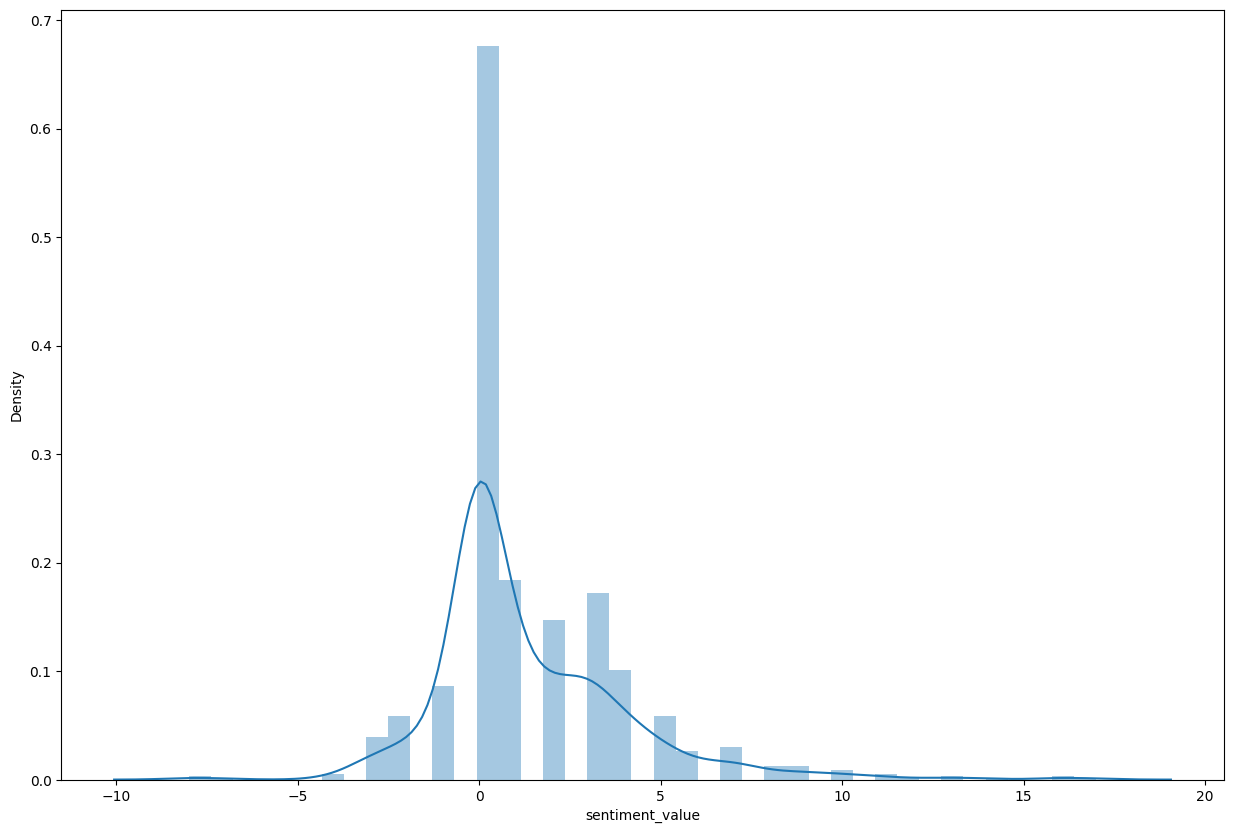

In [240]:
# Plotting the sentiment value for whole tweet
import seaborn as sns
plt.figure(figsize=(15,10))
sns.distplot(sent_df['sentiment_value'])

<Axes: xlabel='index', ylabel='sentiment_value'>

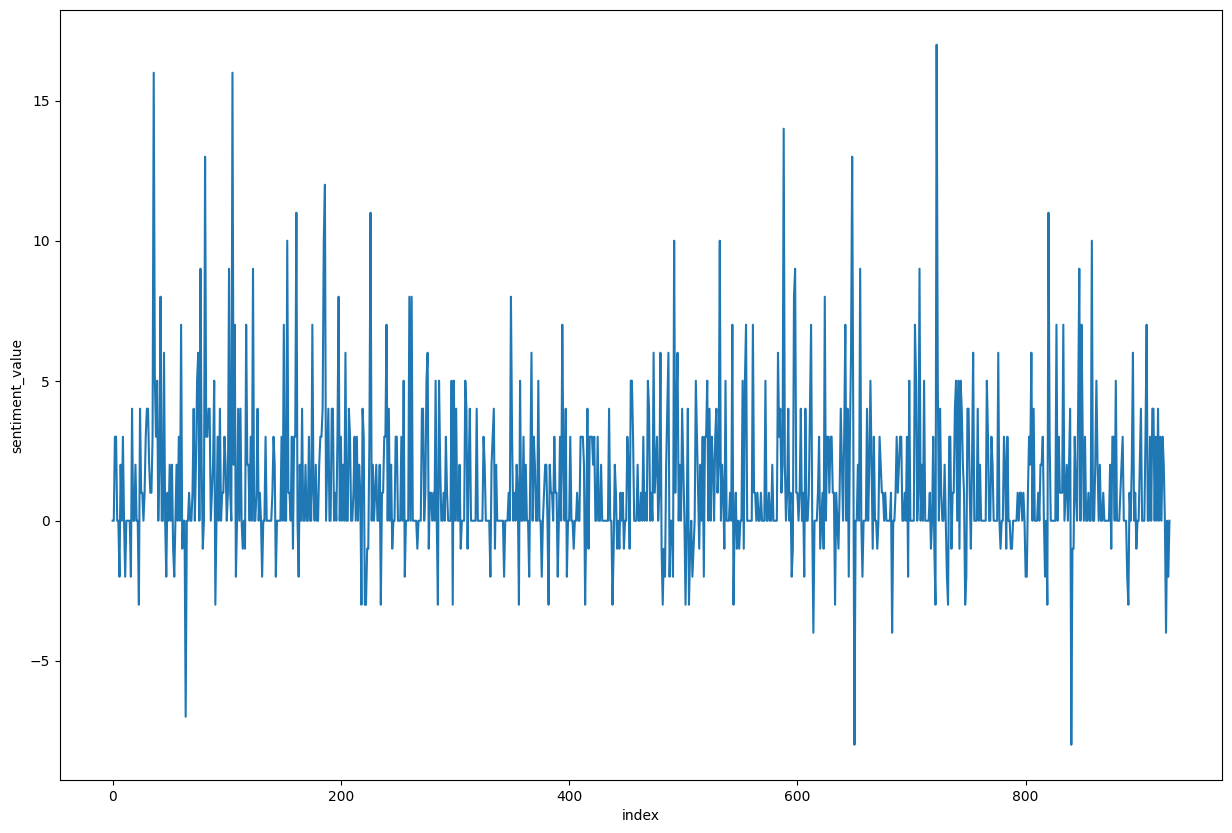

In [241]:
plt.figure(figsize=(15, 10))
sns.lineplot(y='sentiment_value',x='index',data=sent_df)

# Using different Sentiment Analyzing techniques

## 1. Manually Defining the Sentiments

In [242]:
def get_sentiment(sentiment_value):
    if sentiment_value < 0:
        return 'Negative'
    elif sentiment_value >0:
        return 'Positive'
    else:
        return 'Neutral'

In [243]:
# Apply the get_sentiment function to the sentiment_value column
sent_df['Sentiment'] = sent_df['sentiment_value'].apply(get_sentiment)

In [244]:
# re-ordering the columns
sent_df = sent_df.iloc[:, [3,0,2,1,4]]
sent_df

,index,sentence,word_count,sentiment_value,Sentiment
0,0,@kunalb11 Im an alien @ID_AA_Carmack Ray trac...,13,0,Neutral
1,1,Have you tried it?,4,0,Neutral
2,2,@joerogan @Spotify Great interview!,4,3,Positive
3,3,@gtera27 Doge is underestimated @teslacn Congr...,13,3,Positive
4,4,Now on to the next for even more!!,8,0,Neutral
...,...,...,...,...,...
922,922,"@kenyanwalstreet Not actually a payout, just a...",11,0,Neutral
923,923,"It may never pay out, as the stock cant b ht...",31,-4,Negative
924,924,Details Aug 28.,3,0,Neutral
925,925,AI symbiosis while u wait @vistacruiser7 @flcn...,47,-2,Negative


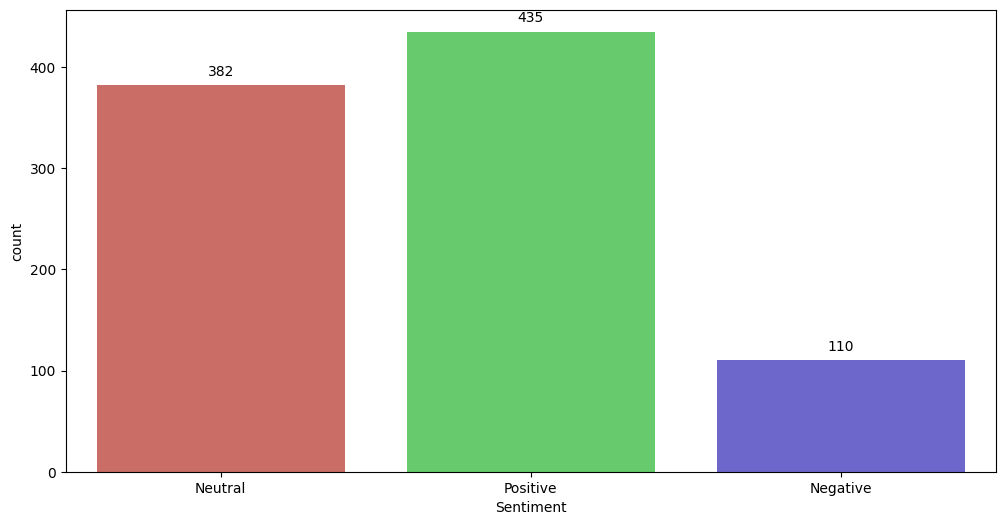

In [245]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Sentiment', data=sent_df, palette='hls')

# Annotate each bar with its count as integer
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

#          

## 2. Using NLTK's Sentiment Intensity Analyzer(SIA)

In [246]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [256]:
sent_df1 = sent_df.copy()
sent_df1

,index,sentence,word_count,sentiment_value,Sentiment
0,0,@kunalb11 Im an alien @ID_AA_Carmack Ray trac...,13,0,Neutral
1,1,Have you tried it?,4,0,Neutral
2,2,@joerogan @Spotify Great interview!,4,3,Positive
3,3,@gtera27 Doge is underestimated @teslacn Congr...,13,3,Positive
4,4,Now on to the next for even more!!,8,0,Neutral
...,...,...,...,...,...
922,922,"@kenyanwalstreet Not actually a payout, just a...",11,0,Neutral
923,923,"It may never pay out, as the stock cant b ht...",31,-4,Negative
924,924,Details Aug 28.,3,0,Neutral
925,925,AI symbiosis while u wait @vistacruiser7 @flcn...,47,-2,Negative


In [257]:
sent_df1.drop(['sentiment_value','Sentiment'], axis = 1, inplace = True)
sent_df1

,index,sentence,word_count
0,0,@kunalb11 Im an alien @ID_AA_Carmack Ray trac...,13
1,1,Have you tried it?,4
2,2,@joerogan @Spotify Great interview!,4
3,3,@gtera27 Doge is underestimated @teslacn Congr...,13
4,4,Now on to the next for even more!!,8
...,...,...,...
922,922,"@kenyanwalstreet Not actually a payout, just a...",11
923,923,"It may never pay out, as the stock cant b ht...",31
924,924,Details Aug 28.,3
925,925,AI symbiosis while u wait @vistacruiser7 @flcn...,47


In [258]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

def analyze_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    sentiment_score = sia.polarity_scores(text)['compound']
    return sentiment_score

# Apply sentiment analysis to the 'sentence' column and create 'sentiment_SIA' and 'sentiment_score' columns
sent_df1['Sentiment_score'] = sent_df1['sentence'].apply(analyze_sentiment)
sent_df1['Sentiment_SIA'] = sent_df1['Sentiment_score'].apply(lambda score: "Positive" if score >= 0.05 else ("Negative" if score <= -0.05 else "Neutral"))

sent_df1

,index,sentence,word_count,Sentiment_score,Sentiment_SIA
0,0,@kunalb11 Im an alien @ID_AA_Carmack Ray trac...,13,0.0000,Neutral
1,1,Have you tried it?,4,0.0000,Neutral
2,2,@joerogan @Spotify Great interview!,4,0.6588,Positive
3,3,@gtera27 Doge is underestimated @teslacn Congr...,13,0.7650,Positive
4,4,Now on to the next for even more!!,8,0.0000,Neutral
...,...,...,...,...,...
922,922,"@kenyanwalstreet Not actually a payout, just a...",11,0.0000,Neutral
923,923,"It may never pay out, as the stock cant b ht...",31,-0.1783,Negative
924,924,Details Aug 28.,3,0.0000,Neutral
925,925,AI symbiosis while u wait @vistacruiser7 @flcn...,47,0.5916,Positive


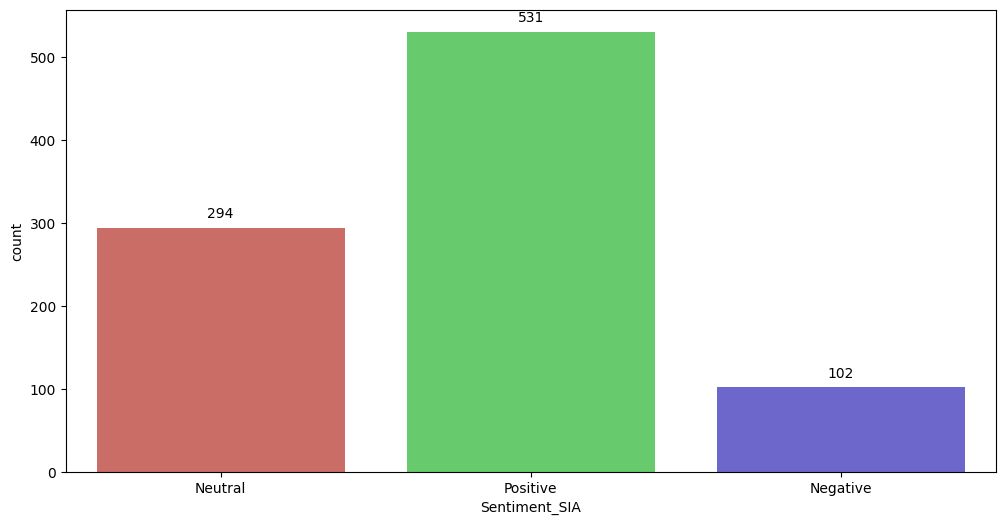

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Sentiment_SIA', data=sent_df1, palette='hls')

# Annotate each bar with its count as integer
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

#     

## 3. Using TextBlob

In [263]:
sent_df2 = sent_df.copy()
sent_df2

,index,sentence,word_count,sentiment_value,Sentiment
0,0,@kunalb11 Im an alien @ID_AA_Carmack Ray trac...,13,0,Neutral
1,1,Have you tried it?,4,0,Neutral
2,2,@joerogan @Spotify Great interview!,4,3,Positive
3,3,@gtera27 Doge is underestimated @teslacn Congr...,13,3,Positive
4,4,Now on to the next for even more!!,8,0,Neutral
...,...,...,...,...,...
922,922,"@kenyanwalstreet Not actually a payout, just a...",11,0,Neutral
923,923,"It may never pay out, as the stock cant b ht...",31,-4,Negative
924,924,Details Aug 28.,3,0,Neutral
925,925,AI symbiosis while u wait @vistacruiser7 @flcn...,47,-2,Negative


In [264]:
sent_df2.drop(['sentiment_value','Sentiment'], axis = 1, inplace = True)
sent_df2

,index,sentence,word_count
0,0,@kunalb11 Im an alien @ID_AA_Carmack Ray trac...,13
1,1,Have you tried it?,4
2,2,@joerogan @Spotify Great interview!,4
3,3,@gtera27 Doge is underestimated @teslacn Congr...,13
4,4,Now on to the next for even more!!,8
...,...,...,...
922,922,"@kenyanwalstreet Not actually a payout, just a...",11
923,923,"It may never pay out, as the stock cant b ht...",31
924,924,Details Aug 28.,3
925,925,AI symbiosis while u wait @vistacruiser7 @flcn...,47


In [265]:
import pandas as pd
from textblob import TextBlob

def get_sentiment_and_score(text):
    analysis = TextBlob(text)
    sentiment = 'Positive' if analysis.sentiment.polarity > 0 else 'Negative' if analysis.sentiment.polarity < 0 else 'Neutral'
    return pd.Series([analysis.sentiment.polarity, sentiment], index=['Sentiment_Score', 'Sentiment_textblob'])

# Apply sentiment analysis and create new columns 'Sentiment_Score' and 'Sentiment_textblob'
sent_df2[['Sentiment_Score', 'Sentiment_textblob']] = sent_df2['sentence'].apply(get_sentiment_and_score)

sent_df2


,index,sentence,word_count,Sentiment_Score,Sentiment_textblob
0,0,@kunalb11 Im an alien @ID_AA_Carmack Ray trac...,13,-0.250000,Negative
1,1,Have you tried it?,4,0.000000,Neutral
2,2,@joerogan @Spotify Great interview!,4,1.000000,Positive
3,3,@gtera27 Doge is underestimated @teslacn Congr...,13,0.300000,Positive
4,4,Now on to the next for even more!!,8,0.390625,Positive
...,...,...,...,...,...
922,922,"@kenyanwalstreet Not actually a payout, just a...",11,0.000000,Neutral
923,923,"It may never pay out, as the stock cant b ht...",31,0.016667,Positive
924,924,Details Aug 28.,3,0.000000,Neutral
925,925,AI symbiosis while u wait @vistacruiser7 @flcn...,47,0.184524,Positive


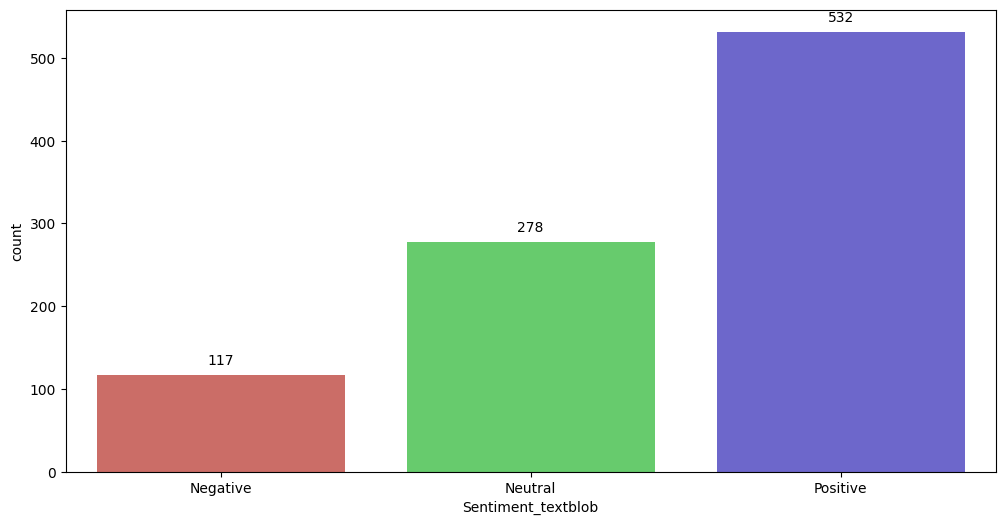

In [266]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Sentiment_textblob', data=sent_df2, palette='hls')

# Annotate each bar with its count as integer
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()